In [ ]:
#@title 0. Colab setup: install extras and mount Google Drive

!pip install -q scikit-image

from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title 1. Imports and Global Config

import os
import random
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
import torchvision.transforms.functional as TF
import torchvision.models as models

from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# -------------------------
# CONFIG: easy to modify
# -------------------------
CONFIG = {
    # Reproducibility
    "seed": 42,

    # Data / training
    "batch_size": 64,
    "num_epochs": 20,
    "learning_rate": 2e-4,
    "weight_decay": 0.0,

    # Optimizer options: "adam", "sgd"
    "optimizer_type": "adam",

    # Loss options: "l1", "l2", "l1+perceptual"
    "loss_type": "l1",

    # Perceptual loss settings (used only if loss_type includes "perceptual")
    "perceptual_weight": 0.1,                   # λ_perc in L = L1 + λ_perc * L_perc
    "perceptual_layers": ["relu3_3", "relu4_3"],  # VGG layers used for perceptual features

    # U-Net architecture
    "unet_in_channels": 1,      # grayscale input
    "unet_out_channels": 3,     # RGB output
    "unet_base_channels": 64,   # base feature channels
    "unet_depth": 4,            # down-sampling steps (4 works well for 96x96)
    "unet_dropout": 0.0,        # dropout rate in DoubleConv blocks

    # Data augmentation (geometric only so targets stay valid)
    "augment_random_horizontal_flip": True,
    "augment_random_crop": False,  # STL-10 is already 96x96
    "random_crop_padding": 4,      # only used if random crop enabled

    # Dataloader
    "num_workers": 2,

    # Google Drive saving
    "save_to_drive_dir": "/content/drive/MyDrive/stl10_colorization_models",
    "experiment_name": "unet_stl10_colorization",

    # Evaluation (set to None to use full test set)
    "max_val_batches_for_metrics": None,
}

In [ ]:
#@title 2. Reproducibility Helpers

def set_seed(seed: int):
    """
    Set random seeds and deterministic flags so training is reproducible.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Make cuDNN deterministic (slower but reproducible)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def make_worker_init_fn(base_seed: int):
    """
    Ensure each DataLoader worker has a deterministic but different seed.
    """
    def worker_init_fn(worker_id):
        worker_seed = base_seed + worker_id
        np.random.seed(worker_seed)
        random.seed(worker_seed)
    return worker_init_fn

In [ ]:
#@title 3. Dataset: STL-10 Grayscale → Color Pairs

class STL10ColorizationDataset(Dataset):
    """
    Wraps torchvision.datasets.STL10 to produce (gray, color) pairs.

    - color: RGB image tensor in [0, 1], shape [3, 96, 96]
    - gray:  1-channel grayscale tensor in [0, 1], shape [1, 96, 96]
    """
    def __init__(self, root, split: str, transform=None, download: bool = True):
        super().__init__()
        assert split in ["train", "test"], "Use 'train' or 'test' splits for labeled STL-10."
        self.stl10 = torchvision.datasets.STL10(
            root=root,
            split=split,
            download=download,
            transform=None  # we'll apply transforms manually
        )
        self.transform = transform

    def __len__(self):
        return len(self.stl10)

    def __getitem__(self, idx):
        img, label = self.stl10[idx]  # PIL RGB image, 96x96

        # Apply transforms (e.g., flip/crop) to RGB image
        if self.transform is not None:
            img = self.transform(img)  # Tensor [3, H, W] in [0,1]
        else:
            img = TF.to_tensor(img)

        color = img  # target color image [3, 96, 96]

        # Convert to grayscale (1 channel) from transformed color
        gray = TF.rgb_to_grayscale(color, num_output_channels=1)  # [1, 96, 96]

        return gray, color


def get_transforms(config):
    """
    Returns training and test transforms for STL-10 (96x96 images).
    Only geometric augmentations applied; they preserve the grayscale/color pairing.
    """
    train_transforms = []
    if config["augment_random_crop"]:
        train_transforms.append(
            transforms.RandomCrop(96, padding=config["random_crop_padding"])
        )
    if config["augment_random_horizontal_flip"]:
        train_transforms.append(transforms.RandomHorizontalFlip())

    # Always end with ToTensor() for [0,1] range.
    train_transforms.append(transforms.ToTensor())
    train_transform = transforms.Compose(train_transforms)

    # Test / validation: no augmentation, just convert to tensor.
    test_transform = transforms.ToTensor()

    return train_transform, test_transform


def create_dataloaders(config):
    """
    Create custom 10,000 train / 3,000 test dataloaders
    by merging STL10 train+test and re-splitting manually.
    """
    train_transform, test_transform = get_transforms(config)
    worker_init_fn = make_worker_init_fn(config["seed"])

    # Load original STL10 train (5000) and test (8000)
    train_raw = STL10ColorizationDataset(
        root="./data_stl10", split="train", download=True, transform=train_transform
    )
    test_raw = STL10ColorizationDataset(
        root="./data_stl10", split="test", download=True, transform=test_transform
    )

    # Combine → total 13,000 samples
    full_gray = torch.utils.data.ConcatDataset([train_raw, test_raw])

    # New sizes
    new_train_size = 10000
    new_test_size = 3000

    # Deterministic split
    g = torch.Generator()
    g.manual_seed(config["seed"])

    train_dataset, test_dataset = torch.utils.data.random_split(
        full_gray, [new_train_size, new_test_size], generator=g
    )

    # Build dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config["batch_size"],
        shuffle=True,
        num_workers=config["num_workers"],
        pin_memory=True,
        worker_init_fn=worker_init_fn,
        generator=g,
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=config["batch_size"],
        shuffle=False,
        num_workers=config["num_workers"],
        pin_memory=True,
        worker_init_fn=worker_init_fn,
    )

    print(f"Custom split created: Train = {new_train_size}, Test = {new_test_size}")
    return train_loader, test_loader


In [ ]:
#@title 4. Model: U-Net for Colorization

class DoubleConv(nn.Module):
    """
    Basic building block: (Conv -> BN -> ReLU) * 2, with optional dropout.
    Used both in encoder and decoder.
    """
    def __init__(self, in_ch, out_ch, use_dropout=False, dropout_p=0.0):
        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        ]
        if use_dropout and dropout_p > 0:
            layers.append(nn.Dropout2d(dropout_p))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


class UNet(nn.Module):
    """
    Configurable U-Net for image-to-image tasks like colorization.

    - in_channels:   input channels (1 for grayscale)
    - out_channels:  output channels (3 for RGB)
    - base_channels: number of feature maps at the first level
    - depth:         how many times to downsample with MaxPool2d(2)
    """
    def __init__(
        self,
        in_channels=1,
        out_channels=3,
        base_channels=64,
        depth=4,
        dropout=0.0
    ):
        super().__init__()
        self.depth = depth
        self.pool = nn.MaxPool2d(2)

        self.enc_convs = nn.ModuleList()
        self.up_trans = nn.ModuleList()
        self.dec_convs = nn.ModuleList()

        # Encoder path
        enc_channels = []
        for i in range(depth):
            in_ch = in_channels if i == 0 else enc_channels[-1]
            out_ch = base_channels * (2 ** i)
            self.enc_convs.append(
                DoubleConv(in_ch, out_ch, use_dropout=(dropout > 0), dropout_p=dropout)
            )
            enc_channels.append(out_ch)

        # Bottleneck
        bottleneck_ch = enc_channels[-1] * 2
        self.bottleneck = DoubleConv(
            enc_channels[-1],
            bottleneck_ch,
            use_dropout=(dropout > 0),
            dropout_p=dropout
        )

        # Decoder path
        dec_in_ch = bottleneck_ch
        for i in reversed(range(depth)):
            # Upsampling via transposed conv
            self.up_trans.append(
                nn.ConvTranspose2d(dec_in_ch, enc_channels[i], kernel_size=2, stride=2)
            )
            # After concatenation with encoder features, channels double
            self.dec_convs.append(
                DoubleConv(
                    enc_channels[i] * 2,
                    enc_channels[i],
                    use_dropout=(dropout > 0),
                    dropout_p=dropout
                )
            )
            dec_in_ch = enc_channels[i]

        # Final 1x1 conv to produce output RGB channels
        self.final_conv = nn.Conv2d(enc_channels[0], out_channels, kernel_size=1)

    def forward(self, x):
        enc_feats = []

        # Encoder
        for enc in self.enc_convs:
            x = enc(x)
            enc_feats.append(x)
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder
        for i in range(self.depth):
            x = self.up_trans[i](x)
            enc_feat = enc_feats[-(i + 1)]

            # Handle size mismatches if any
            if x.shape[-2:] != enc_feat.shape[-2:]:
                diff_y = enc_feat.size(-2) - x.size(-2)
                diff_x = enc_feat.size(-1) - x.size(-1)
                enc_feat = enc_feat[
                    :,
                    :,
                    diff_y // 2 : enc_feat.size(-2) - diff_y // 2,
                    diff_x // 2 : enc_feat.size(-1) - diff_x // 2,
                ]

            x = torch.cat([enc_feat, x], dim=1)
            x = self.dec_convs[i](x)

        # Sigmoid to map to [0,1] since targets are in that range
        x = self.final_conv(x)
        x = torch.sigmoid(x)
        return x


def build_model(config, device):
    """
    Construct the U-Net according to the config, and move to device (CPU/GPU).
    """
    model = UNet(
        in_channels=config["unet_in_channels"],
        out_channels=config["unet_out_channels"],
        base_channels=config["unet_base_channels"],
        depth=config["unet_depth"],
        dropout=config["unet_dropout"],
    )
    model = model.to(device)
    return model

In [ ]:
#@title 5. Loss and Metrics (with optional perceptual loss)

# Mapping from human-readable VGG16 layer names to indices in vgg.features
VGG16_LAYER_MAP = {
    "relu1_2": 3,
    "relu2_2": 8,
    "relu3_3": 15,
    "relu4_3": 22,
    "relu5_3": 29,
}


class VGGFeatureExtractor(nn.Module):
    """
    Extracts intermediate feature maps from a pretrained VGG16 network.

    - Uses VGG16 pretrained on ImageNet.
    - Normalizes input images with ImageNet mean/std.
    - Returns a list of feature maps from requested layers.
    """
    def __init__(self, layer_names):
        super().__init__()
        # Convert requested layer names (e.g., ["relu3_3", "relu4_3"]) to indices
        layer_indices = []
        for name in layer_names:
            if name not in VGG16_LAYER_MAP:
                raise ValueError(f"Unknown VGG16 layer name: {name}")
            layer_indices.append(VGG16_LAYER_MAP[name])
        self.layer_indices = set(layer_indices)

        # Pretrained VGG16 (features only)
        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        self.features = vgg.features.eval()  # keep in eval mode

        # Do NOT train VGG
        for param in self.features.parameters():
            param.requires_grad = False

        # Register ImageNet normalization buffers (so they move with .to(device))
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
        std  = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
        self.register_buffer("mean", mean)
        self.register_buffer("std", std)

    def forward(self, x):
        """
        x: [B, 3, H, W] in [0,1] RGB.
        Returns: list of feature maps taken from the requested layers.
        """
        # Normalize to ImageNet stats
        x = (x - self.mean) / self.std

        feats = []
        for idx, layer in enumerate(self.features):
            x = layer(x)
            if idx in self.layer_indices:
                feats.append(x)
        return feats


class PerceptualLoss(nn.Module):
    """
    Perceptual loss using VGG features.

    L_perc = sum_i L1(VGG_i(pred), VGG_i(target))
    """
    def __init__(self, feature_extractor: VGGFeatureExtractor, use_l1=True):
        super().__init__()
        self.feature_extractor = feature_extractor
        self.use_l1 = use_l1
        self.l1 = nn.L1Loss()
        self.l2 = nn.MSELoss()

    def forward(self, pred, target):
        """
        pred, target: [B, 3, H, W] in [0,1]
        Returns scalar perceptual loss.
        """
        pred_feats = self.feature_extractor(pred)
        tgt_feats = self.feature_extractor(target)

        loss = 0.0
        for pf, tf in zip(pred_feats, tgt_feats):
            if self.use_l1:
                loss = loss + self.l1(pf, tf)
            else:
                loss = loss + self.l2(pf, tf)
        return loss


def get_loss_objects(config, device):
    """
    Returns:
      pixel_loss_fn: nn.Module (L1 or L2 on RGB pixels)
      perceptual_loss_fn: PerceptualLoss or None
      perceptual_weight: float (0 if not used)

    Behavior:
      - "l1"  -> pixel L1 only
      - "l2"  -> pixel L2 only
      - "l1+perceptual" -> L1 + λ * PerceptualLoss
    """
    loss_type = config["loss_type"].lower()

    # Pixel-wise loss
    if "l1" in loss_type:
        pixel_loss_fn = nn.L1Loss()
    elif "l2" in loss_type:
        pixel_loss_fn = nn.MSELoss()
    else:
        raise ValueError(f"Unsupported loss_type: {config['loss_type']}")

    # Perceptual loss (optional)
    if "perceptual" in loss_type:
        layer_names = config.get("perceptual_layers", ["relu3_3"])
        vgg_extractor = VGGFeatureExtractor(layer_names).to(device)
        perceptual_loss_fn = PerceptualLoss(vgg_extractor, use_l1=True)
        perceptual_weight = float(config.get("perceptual_weight", 0.1))
    else:
        perceptual_loss_fn = None
        perceptual_weight = 0.0

    return pixel_loss_fn, perceptual_loss_fn, perceptual_weight


def get_optimizer(config, model_params):
    """
    Returns optimizer according to config.
    """
    opt_type = config["optimizer_type"].lower()
    lr = config["learning_rate"]
    wd = config["weight_decay"]

    if opt_type == "adam":
        return optim.Adam(model_params, lr=lr, weight_decay=wd)
    elif opt_type == "sgd":
        return optim.SGD(model_params, lr=lr, momentum=0.9, weight_decay=wd)
    else:
        raise ValueError(f"Unsupported optimizer_type: {config['optimizer_type']}")


@torch.no_grad()
def compute_batch_psnr_ssim(pred, target):
    """
    Compute PSNR and SSIM for a single batch.

    pred, target: [B, 3, H, W] in [0,1].
    Returns: (avg_psnr, avg_ssim) over the batch.
    """
    pred = pred.clamp(0.0, 1.0).cpu()
    target = target.clamp(0.0, 1.0).cpu()

    pred_np = pred.permute(0, 2, 3, 1).numpy()   # [B, H, W, C]
    target_np = target.permute(0, 2, 3, 1).numpy()

    psnr_sum, ssim_sum = 0.0, 0.0
    batch_size = pred_np.shape[0]

    for i in range(batch_size):
        p = pred_np[i]
        t = target_np[i]
        psnr_val = peak_signal_noise_ratio(t, p, data_range=1.0)
        ssim_val = structural_similarity(t, p, data_range=1.0, channel_axis=-1)
        psnr_sum += psnr_val
        ssim_sum += ssim_val

    return psnr_sum / batch_size, ssim_sum / batch_size

In [ ]:
#@title 6. Training & Evaluation Loops

@torch.no_grad()
def compute_channel_mae(pred, target):
    """
    pred, target: [B, 3, H, W] in [0,1]
    Returns MAE per channel as tensor [3]
    """
    diff = (pred - target).abs()
    # reduce over batch, h, w
    mae_channels = diff.mean(dim=(0, 2, 3))   # -> [3]
    return mae_channels

def train_one_epoch(
    model,
    dataloader,
    optimizer,
    pixel_loss_fn,
    device,
    epoch,
    perceptual_loss_fn=None,
    perceptual_weight=0.0,
):
    """
    Train the model for one epoch.

    If perceptual_loss_fn is not None and perceptual_weight > 0,
    total loss = pixel_loss + perceptual_weight * perceptual_loss.
    """
    model.train()
    running_loss = 0.0

    channel_mae_sum = torch.zeros(3, device=device)
    num_batches = 0

    for batch_idx, (gray, color) in enumerate(dataloader):
        gray = gray.to(device, non_blocking=True)
        color = color.to(device, non_blocking=True)

        optimizer.zero_grad()
        pred_color = model(gray)

        # per-channel MAE
        mae_channels = compute_channel_mae(pred_color, color)
        channel_mae_sum += mae_channels
        num_batches += 1

        # 1) Pixel-wise loss (L1 or L2)
        pixel_loss = pixel_loss_fn(pred_color, color)

        # 2) Optional perceptual loss
        if (perceptual_loss_fn is not None) and (perceptual_weight > 0.0):
            perc_loss = perceptual_loss_fn(pred_color, color)
            loss = pixel_loss + perceptual_weight * perc_loss
        else:
            perc_loss = torch.tensor(0.0, device=device)
            loss = pixel_loss

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * gray.size(0)

        if (batch_idx + 1) % 100 == 0:
            print(
                f"  [Epoch {epoch+1} | Batch {batch_idx+1}/{len(dataloader)}] "
                f"Pixel: {pixel_loss.item():.4f} | "
                f"Perc: {perc_loss.item():.4f} | "
                f"Total: {loss.item():.4f}"
            )

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_channel_mae = (channel_mae_sum / num_batches).detach().cpu().numpy()
    return epoch_loss, epoch_channel_mae


@torch.no_grad()
def evaluate(
    model,
    dataloader,
    pixel_loss_fn,
    device,
    config,
    perceptual_loss_fn=None,
    perceptual_weight=0.0,
):
    """
    Evaluate model on validation/test dataloader.

    Uses the same combined loss (pixel + λ * perceptual) as training
    to report validation loss. Also computes PSNR, SSIM, and per-channel MAE.
    """
    model.eval()
    running_loss = 0.0
    psnr_total = 0.0
    ssim_total = 0.0
    num_batches = 0

    # NEW: accumulators for test per-channel MAE
    channel_mae_sum = torch.zeros(3, device=device)

    max_batches = config["max_val_batches_for_metrics"]

    for batch_idx, (gray, color) in enumerate(dataloader):
        gray = gray.to(device, non_blocking=True)
        color = color.to(device, non_blocking=True)

        pred_color = model(gray)

        # Combined loss
        pixel_loss = pixel_loss_fn(pred_color, color)
        if (perceptual_loss_fn is not None) and (perceptual_weight > 0.0):
            perc_loss = perceptual_loss_fn(pred_color, color)
            loss = pixel_loss + perceptual_weight * perc_loss
        else:
            loss = pixel_loss

        running_loss += loss.item() * gray.size(0)

        # PSNR / SSIM
        batch_psnr, batch_ssim = compute_batch_psnr_ssim(pred_color, color)
        psnr_total += batch_psnr
        ssim_total += batch_ssim

        # NEW: per-channel MAE on this batch
        mae_channels = compute_channel_mae(pred_color, color)
        channel_mae_sum += mae_channels

        num_batches += 1

        if (max_batches is not None) and (num_batches >= max_batches):
            break

    epoch_loss = running_loss / len(dataloader.dataset)
    mean_psnr = psnr_total / num_batches
    mean_ssim = ssim_total / num_batches

    # NEW: average per-channel MAE over all batches
    epoch_channel_mae = (channel_mae_sum / num_batches).detach().cpu().numpy()

    # NOTE: now we return 4 things
    return epoch_loss, mean_psnr, mean_ssim, epoch_channel_mae


In [ ]:
#@title 7. Visualization Helpers


@torch.no_grad()
def plot_training_curves(history):
    """
    Plot train/val loss and PSNR/SSIM curves across epochs.
    """
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    # PSNR
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history["val_psnr"], label="Val PSNR")
    plt.xlabel("Epoch")
    plt.ylabel("PSNR (dB)")
    plt.title("Validation PSNR")
    plt.legend()

    # SSIM
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history["val_ssim"], label="Val SSIM")
    plt.xlabel("Epoch")
    plt.ylabel("SSIM")
    plt.title("Validation SSIM")
    plt.legend()

    plt.tight_layout()
    plt.show()


@torch.no_grad()
def plot_rgb_channel_errors(history):
    """
    Plot three separate lines for Train and Test per-channel MAE across epochs.
    """
    epochs = range(1, len(history["train_mae_r"]) + 1)

    plt.figure(figsize=(10, 6))

    # Train curves
    plt.plot(epochs, history["train_mae_r"], label="Train Red MAE", linewidth=2, color = 'red')
    plt.plot(epochs, history["train_mae_g"], label="Train Green MAE", linewidth=2, color = 'green')
    plt.plot(epochs, history["train_mae_b"], label="Train Blue MAE", linewidth=2, color = 'blue')

    # Test/Val curves (dashed)
    plt.plot(epochs, history["val_mae_r"], "--", label="Test Red MAE", linewidth=2, color = 'darkred')
    plt.plot(epochs, history["val_mae_g"], "--", label="Test Green MAE", linewidth=2, color = 'darkgreen')
    plt.plot(epochs, history["val_mae_b"], "--", label="Test Blue MAE", linewidth=2, color = 'darkblue')

    plt.xlabel("Epoch")
    plt.ylabel("Mean Absolute Error")
    plt.title("Per-Channel Training and Test Error Across Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()




# Kept for saving only — no longer shown after training
@torch.no_grad()
def visualize_examples(model, dataloader, device, num_samples=6):
    pass  # Purposefully disabled visualization


# -------------------------
# Residual / Hotspot visualization (new)
# -------------------------
@torch.no_grad()
def visualize_residuals(model, dataloader, device, num_samples=6):
    """
    Visualize residual (error) between predicted and ground-truth images.
    Shows input, prediction, target, and residual (abs(pred - target)).
    """
    model.eval()
    gray, color = next(iter(dataloader))
    gray = gray.to(device)
    color = color.to(device)

    pred_color = model(gray).clamp(0.0, 1.0)

    gray = gray[:num_samples].cpu()
    color = color[:num_samples].cpu()
    pred_color = pred_color[:num_samples].cpu()
    residual = torch.abs(pred_color - color)

    plt.figure(figsize=(12, 8))
    for i in range(num_samples):
        # Row 1: Input grayscale
        plt.subplot(4, num_samples, i + 1)
        plt.axis("off")
        plt.title("Input")
        plt.imshow(gray[i, 0, :, :], cmap="gray")

        # Row 2: Predicted color
        plt.subplot(4, num_samples, num_samples + i + 1)
        plt.axis("off")
        plt.title("Predicted")
        plt.imshow(pred_color[i].permute(1, 2, 0))

        # Row 3: Ground truth
        plt.subplot(4, num_samples, 2 * num_samples + i + 1)
        plt.axis("off")
        plt.title("Target")
        plt.imshow(color[i].permute(1, 2, 0))

        # Row 4: Residual / hotspot
        plt.subplot(4, num_samples, 3 * num_samples + i + 1)
        plt.axis("off")
        plt.title("Residual")
        plt.imshow(residual[i].permute(1, 2, 0).mean(dim=2), cmap="hot")

    plt.tight_layout()
    plt.show()

    # Return sample tensors so they can be saved
    return {
        "gray": gray,
        "pred": pred_color,
        "target": color,
        "residual": residual
    }



In [ ]:
#@title 8. Model Saving to Google Drive (with residuals)

def save_model_to_drive(model, config, history, sample_residuals=None):
    """
    Save model parameters, training history, config, and residual sample
    (optional) to Google Drive in a single .pth file.
    """
    os.makedirs(config["save_to_drive_dir"], exist_ok=True)

    lr_str = str(config["learning_rate"]).replace(".", "p")
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    filename = (
        f"{config['experiment_name']}"
        f"_unetDepth{config['unet_depth']}"
        f"_baseCh{config['unet_base_channels']}"
        f"_bs{config['batch_size']}"
        f"_lr{lr_str}"
        f"_loss{config['loss_type']}"
        f"_epochs{config['num_epochs']}"
        f"_seed{config['seed']}"
        f"_{timestamp}.pth"
    )

    filepath = os.path.join(config["save_to_drive_dir"], filename)

    save_obj = {
        "model_state_dict": model.state_dict(),
        "config": config,
        "history": history,
        "model_class": "UNet",
    }

    if sample_residuals is not None:
        save_obj["sample_residuals"] = sample_residuals

    torch.save(save_obj, filepath)
    print(f"\nModel saved to Google Drive at:\n  {filepath}")

In [ ]:
#@title 9. Main Training Orchestration

def train_and_evaluate(config):
    """
    High-level function that:
      - sets seeds
      - builds dataloaders, model, optimizer, loss
      - trains for num_epochs
      - evaluates on test set
      - visualizes example outputs and curves
      - saves model to Google Drive
    """
    set_seed(config["seed"])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Data
    train_loader, test_loader = create_dataloaders(config)

    # Model / loss / optimizer
    model = build_model(config, device)
    pixel_loss_fn, perceptual_loss_fn, perceptual_weight = get_loss_objects(config, device)
    optimizer = get_optimizer(config, model.parameters())

    history = {
    "train_loss": [],
    "val_loss": [],
    "val_psnr": [],
    "val_ssim": [],
    "train_mae_r": [],
    "train_mae_g": [],
    "train_mae_b": [],
    "val_mae_r": [],      # NEW
    "val_mae_g": [],      # NEW
    "val_mae_b": [],      # NEW
    }

    # Training loop
    for epoch in range(config["num_epochs"]):
        print(f"\n=== Epoch {epoch+1}/{config['num_epochs']} ===")

        train_loss, train_mae_rgb = train_one_epoch(
            model,
            train_loader,
            optimizer,
            pixel_loss_fn,
            device,
            epoch,
            perceptual_loss_fn=perceptual_loss_fn,
            perceptual_weight=perceptual_weight,
        )

        val_loss, val_psnr, val_ssim, val_mae_rgb = evaluate(
            model,
            test_loader,
            pixel_loss_fn,
            device,
            config,
            perceptual_loss_fn=perceptual_loss_fn,
            perceptual_weight=perceptual_weight,
        )


        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_psnr"].append(val_psnr)
        history["val_ssim"].append(val_ssim)

        # store per-channel training MAE
        history["train_mae_r"].append(float(train_mae_rgb[0]))
        history["train_mae_g"].append(float(train_mae_rgb[1]))
        history["train_mae_b"].append(float(train_mae_rgb[2]))

        # store per-channel validation/test MAE
        history["val_mae_r"].append(float(val_mae_rgb[0]))
        history["val_mae_g"].append(float(val_mae_rgb[1]))
        history["val_mae_b"].append(float(val_mae_rgb[2]))

        print(
            f"Epoch {epoch+1}: Train Loss = {train_loss:.4f} | "
            f"Val Loss = {val_loss:.4f} | PSNR = {val_psnr:.2f} | SSIM = {val_ssim:.4f}\n"
            f"  Train MAE (R,G,B) = {train_mae_rgb}"
        )

    print("\nTraining complete. Final visualizations:")

    # Plot training curves
    plot_training_curves(history)

    # Plot per-channel training MAE curves
    plot_rgb_channel_errors(history)

    # Show residual + capture the dict
    residual_dict = visualize_residuals(model, test_loader, device, num_samples=6)

    # Save to Drive: model + history + residuals
    save_model_to_drive(model, config, history, sample_residuals=residual_dict)

    return model, history


Using device: cuda
Custom split created: Train = 10000, Test = 3000

=== Epoch 1/20 ===
  [Epoch 1 | Batch 100/157] Pixel: 0.0511 | Perc: 0.0000 | Total: 0.0511
Epoch 1: Train Loss = 0.0671 | Val Loss = 0.0549 | PSNR = 23.22 | SSIM = 0.8956
  Train MAE (R,G,B) = [0.07085065 0.04107138 0.08924317]

=== Epoch 2/20 ===
  [Epoch 2 | Batch 100/157] Pixel: 0.0475 | Perc: 0.0000 | Total: 0.0475
Epoch 2: Train Loss = 0.0495 | Val Loss = 0.0466 | PSNR = 24.39 | SSIM = 0.9185
  Train MAE (R,G,B) = [0.05101738 0.02710747 0.07057988]

=== Epoch 3/20 ===
  [Epoch 3 | Batch 100/157] Pixel: 0.0476 | Perc: 0.0000 | Total: 0.0476
Epoch 3: Train Loss = 0.0479 | Val Loss = 0.0477 | PSNR = 24.19 | SSIM = 0.9200
  Train MAE (R,G,B) = [0.04946758 0.0254358  0.06876922]

=== Epoch 4/20 ===
  [Epoch 4 | Batch 100/157] Pixel: 0.0433 | Perc: 0.0000 | Total: 0.0433
Epoch 4: Train Loss = 0.0471 | Val Loss = 0.0465 | PSNR = 24.42 | SSIM = 0.9216
  Train MAE (R,G,B) = [0.04863921 0.02483096 0.06779899]

=== Epoch 5

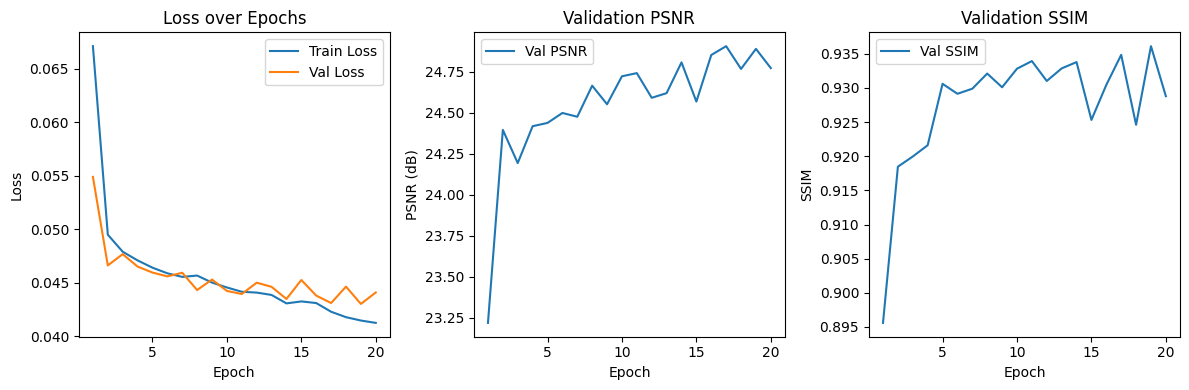

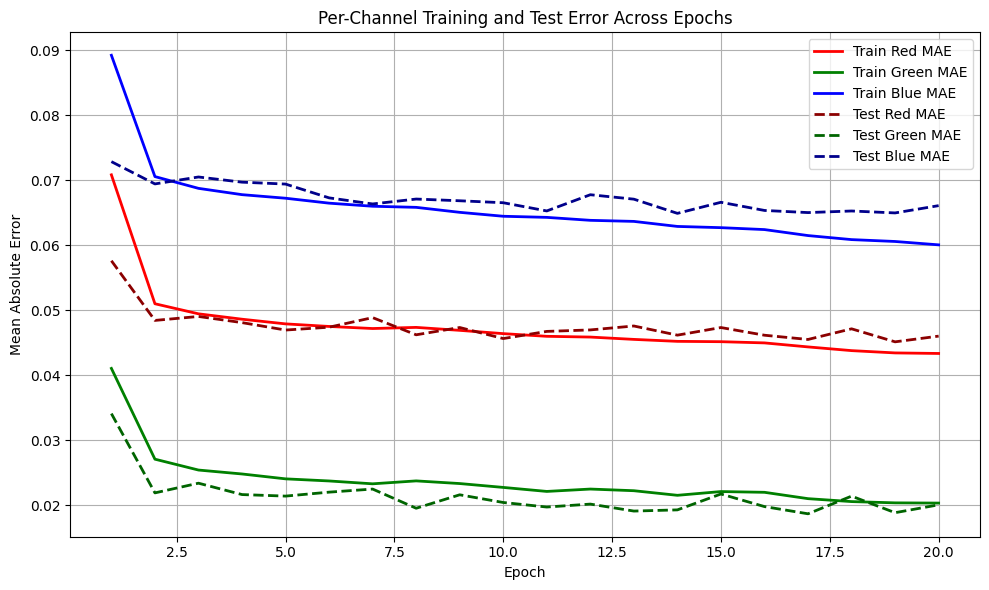

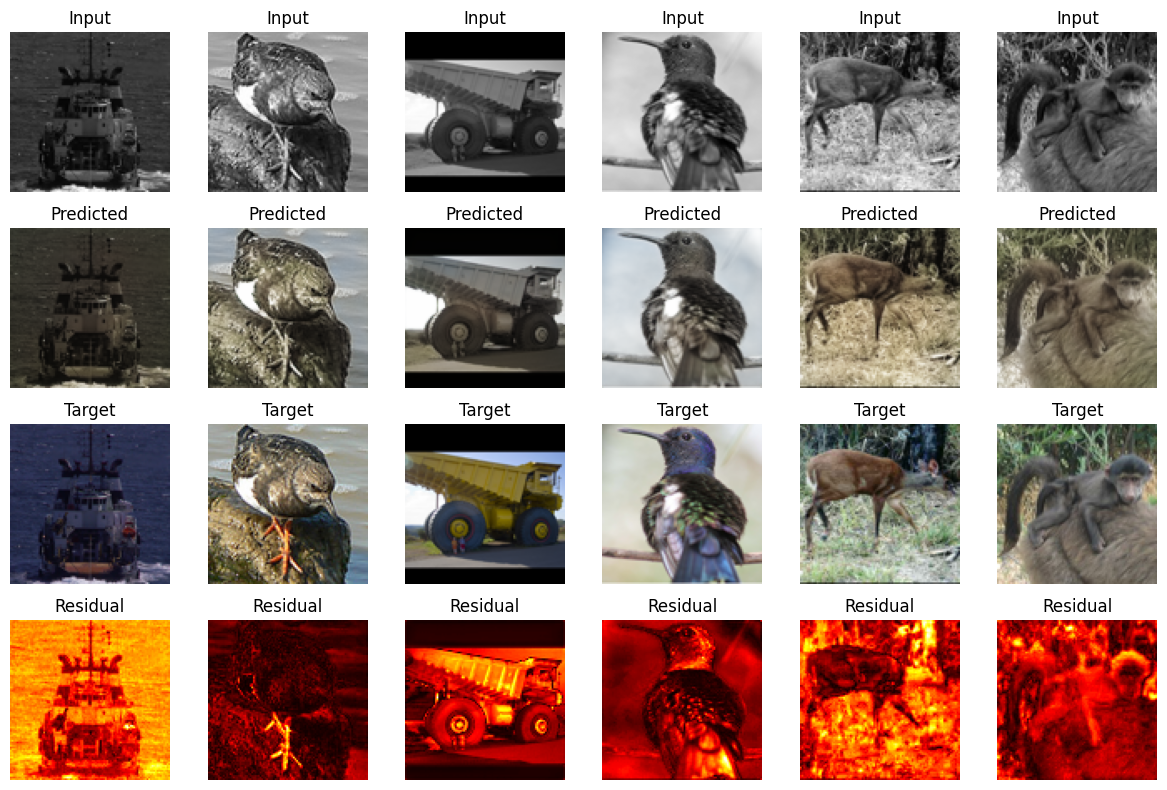


Model saved to Google Drive at:
  /content/drive/MyDrive/stl10_colorization_models/unet_stl10_colorization_unetDepth4_baseCh64_bs64_lr0p0002_lossl1_epochs20_seed42_20251211_031141.pth


In [ ]:
#@title 10. Run everything

if __name__ == "__main__":
    model, history = train_and_evaluate(CONFIG)